In [1]:
# Import Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from pyspark.sql import functions as F

# Styles Config
plt.style.use('default')  
sns.set_theme() 

## EDA - Exploratory Data Analysis

In [2]:
# Check directories and files
import os

print("Verificando diretórios:")
print("/app existe:", os.path.exists("/app"))
print("/app/datalake existe:", os.path.exists("/app/datalake"))
print("/app/datalake/silver existe:", os.path.exists("/app/datalake/silver"))
print("/app/datalake/silver/treino existe:", os.path.exists("/app/datalake/silver/treino"))
print("/app/datalake/silver/itens existe:", os.path.exists("/app/datalake/silver/itens"))

if os.path.exists("/app/datalake/silver"):
    print("\nConteúdo de /app/datalake/silver:")
    print(os.listdir("/app/datalake/silver"))

Verificando diretórios:
/app existe: False
/app/datalake existe: False
/app/datalake/silver existe: False
/app/datalake/silver/treino existe: False
/app/datalake/silver/itens existe: False


In [2]:
# Start Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Silver Data Exploration") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.default.parallelism", "12") \
    .config("spark.sql.shuffle.partitions", "12") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.service.enabled", "true") \
    .config("spark.locality.wait", "0s") \
    .getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/18 20:59:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/18 20:59:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
# Read data (note the correct path for mapped volume)
treino = spark.read \
    .option("mergeSchema", "false") \
    .parquet("datalake/silver/treino") \
    .coalesce(2)

In [5]:
itens = spark.read \
    .option("mergeSchema", "false") \
    .parquet("datalake/silver/itens") \
    .coalesce(2)

In [6]:
# Create temporary tables for SQL
#treino.createOrReplaceTempView("tab_treino")
itens.createOrReplaceTempView("tab_itens")


In [7]:
# 1. Análise inicial dos dados
#print("=== Visão Geral dos Dados ===")
#print("\nSchema dos dados de treino:")
#treino.printSchema()

print("\nSchema dos dados de itens:")
itens.printSchema()


Schema dos dados de itens:
root
 |-- page: string (nullable = true)
 |-- issued: timestamp (nullable = true)
 |-- modified: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- days_since_published: integer (nullable = true)
 |-- days_since_modified: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



In [8]:
#spark.sql("CACHE TABLE tab_treino")
spark.sql("CACHE TABLE tab_itens")

DataFrame[]

In [10]:
result = spark.sql("""
select * from tab_itens limit 10
""")

result.show(10,truncate=False)

+------------------------------------+-------------------+-------------------+------------------------------------------------------------------------------------+--------------------+-------------------+----+-----+---+
|page                                |issued             |modified           |title                                                                               |days_since_published|days_since_modified|year|month|day|
+------------------------------------+-------------------+-------------------+------------------------------------------------------------------------------------+--------------------+-------------------+----+-----+---+
|78698773-9812-446d-be1f-2e70be61e1be|2021-01-01 01:23:31|2021-01-01 01:23:44|Prefeito e vereadores de Tucumã tomam posse; veja lista de eleitos                  |1509                |1509               |2021|1    |1  |
|017964ac-b943-4513-8a8b-6741a38eee00|2021-01-01 02:50:51|2021-01-01 02:50:54|Prefeito e vereadores de São Caetano tomam

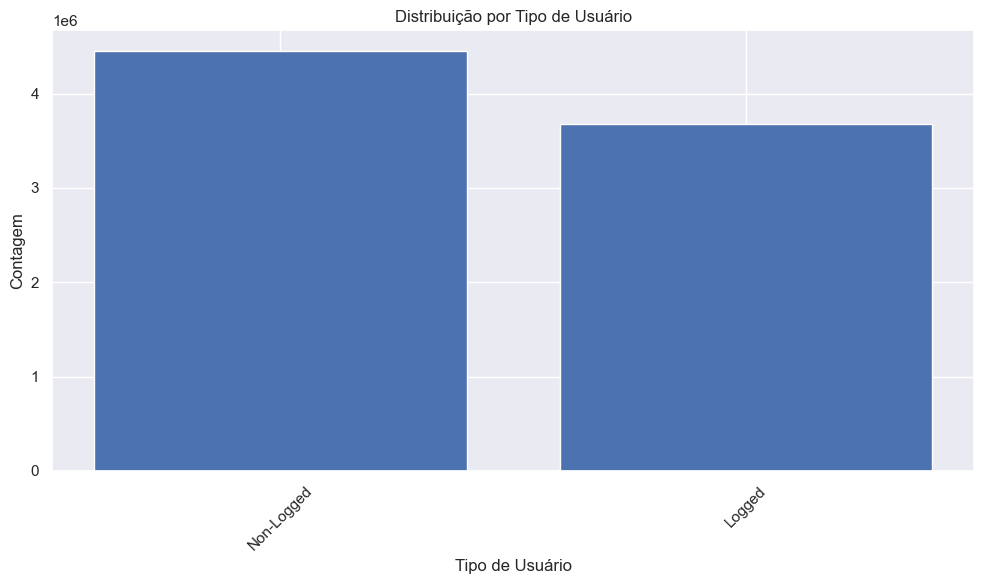

In [8]:
# 2. Análise de distribuição por tipo de usuário
user_type_results = spark.sql("""
    SELECT userType, COUNT(*) as count
    FROM tab_treino
    GROUP BY userType
    ORDER BY count DESC
""").collect()

# Converter para listas
user_types = [row['userType'] for row in user_type_results]
counts = [row['count'] for row in user_type_results]

plt.figure(figsize=(10, 6))
plt.bar(user_types, counts)
plt.title('Distribuição por Tipo de Usuário')
plt.xlabel('Tipo de Usuário')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Métricas chave por tipo de usuário
engagement_summary = spark.sql("""
    SELECT 
        userType,
        CAST(COUNT(DISTINCT userId) AS INT) as num_users,
        CAST(AVG(numberOfClicksHistory) AS INT) as avg_clicks,
        CAST(AVG(timeOnPageHistory) AS INT) as avg_time_seconds,
        CAST(AVG(scrollPercentageHistory) AS INT) as avg_scroll_percent
    FROM tab_treino
    GROUP BY userType
    ORDER BY num_users DESC
""").collect()

# Imprimir resumo
print("=== Resumo de Engajamento por Tipo de Usuário ===")
for row in engagement_summary:
    print(f"\nTipo: {row['userType']}")
    print(f"Número de Usuários: {row['num_users']:,}")
    print(f"Média de Clicks: {row['avg_clicks']}")
    print(f"Tempo Médio (s): {row['avg_time_seconds']}")
    print(f"Scroll Médio (%): {row['avg_scroll_percent']}")

=== Resumo de Engajamento por Tipo de Usuário ===

Tipo: Non-Logged
Número de Usuários: 458,856
Média de Clicks: 11
Tempo Médio (s): 91201
Scroll Médio (%): 52

Tipo: Logged
Número de Usuários: 119,086
Média de Clicks: 12
Tempo Médio (s): 85826
Scroll Médio (%): 55


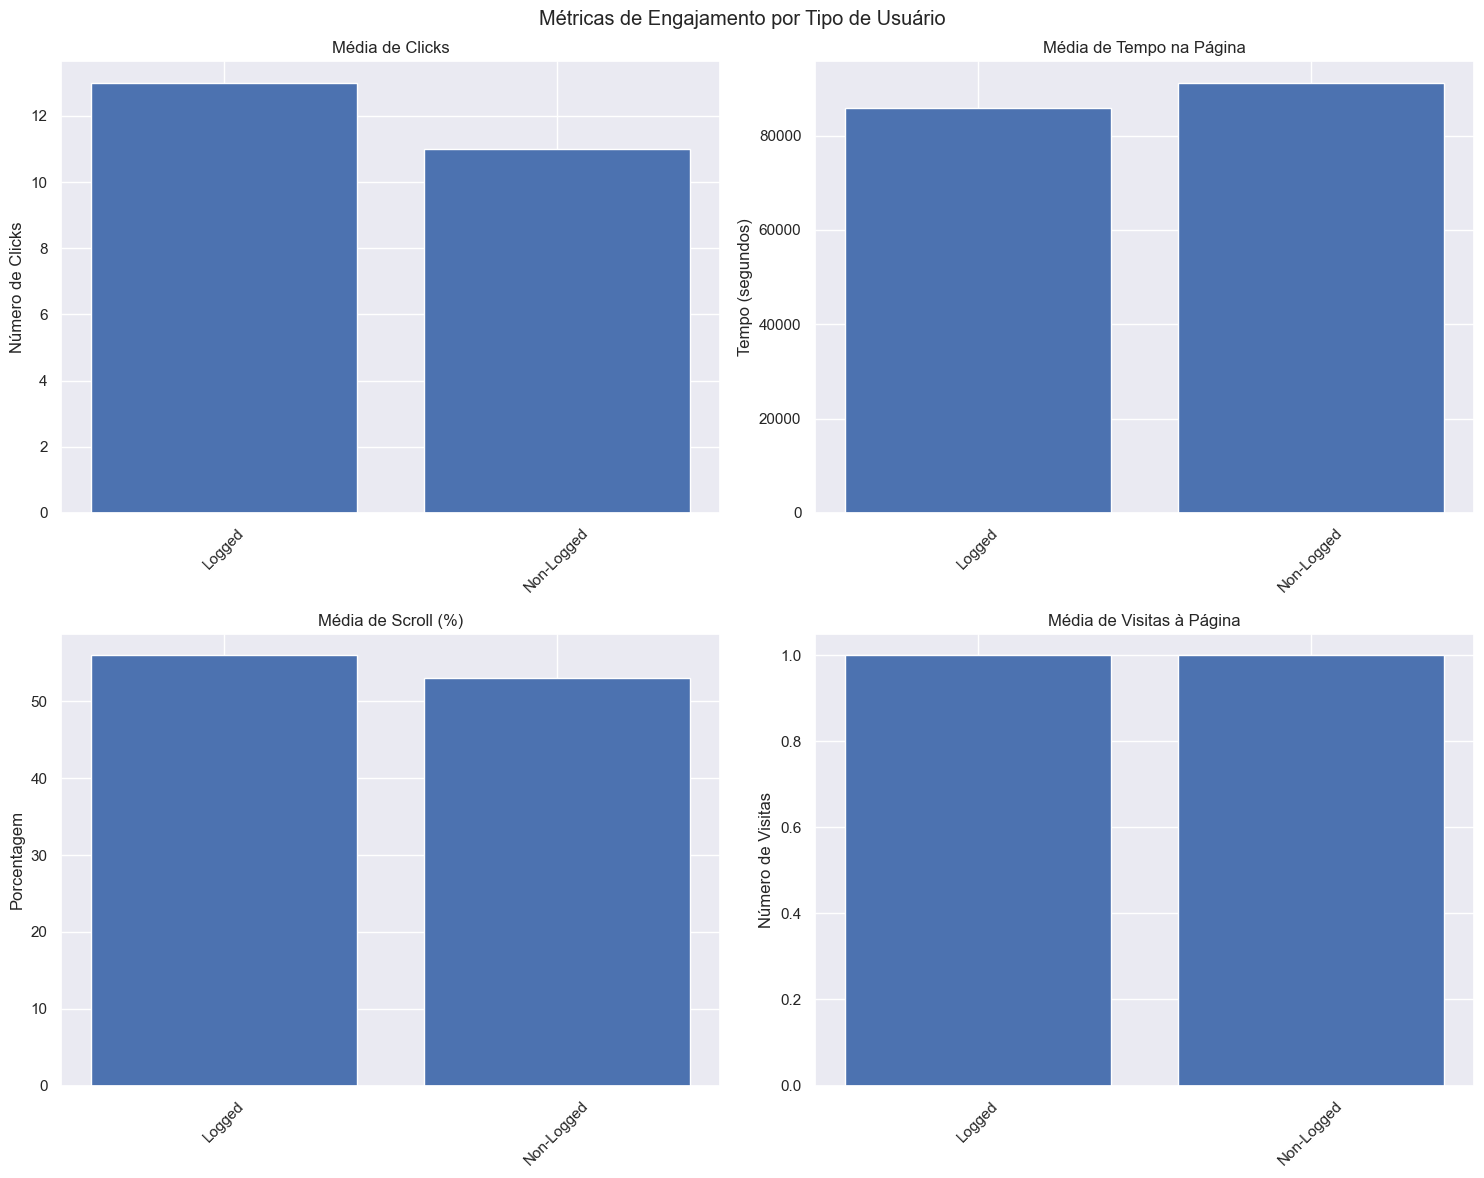

In [10]:
# 3. Análise de engajamento
engagement_results = spark.sql("""
    SELECT 
        userType,
        CAST(ROUND(AVG(numberOfClicksHistory)) AS INT) as avg_clicks,
        CAST(ROUND(AVG(timeOnPageHistory)) AS INT) as avg_time_on_page,
        CAST(ROUND(AVG(scrollPercentageHistory)) AS INT) as avg_scroll,
        CAST(ROUND(AVG(pageVisitsCountHistory)) AS INT) as avg_page_visits
    FROM tab_treino
    GROUP BY userType
""").collect()

# Extrair dados
user_types = [row['userType'] for row in engagement_results]
avg_clicks = [row['avg_clicks'] for row in engagement_results]
avg_time = [row['avg_time_on_page'] for row in engagement_results]
avg_scroll = [row['avg_scroll'] for row in engagement_results]
avg_visits = [row['avg_page_visits'] for row in engagement_results]

# Criar visualização com múltiplos subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Métricas de Engajamento por Tipo de Usuário')

# Clicks
ax1.bar(user_types, avg_clicks)
ax1.set_title('Média de Clicks')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Número de Clicks')

# Time on page
ax2.bar(user_types, avg_time)
ax2.set_title('Média de Tempo na Página')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Tempo (segundos)')

# Scroll percentage
ax3.bar(user_types, avg_scroll)
ax3.set_title('Média de Scroll (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel('Porcentagem')

# Page visits
ax4.bar(user_types, avg_visits)
ax4.set_title('Média de Visitas à Página')
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylabel('Número de Visitas')

plt.tight_layout()
plt.show()

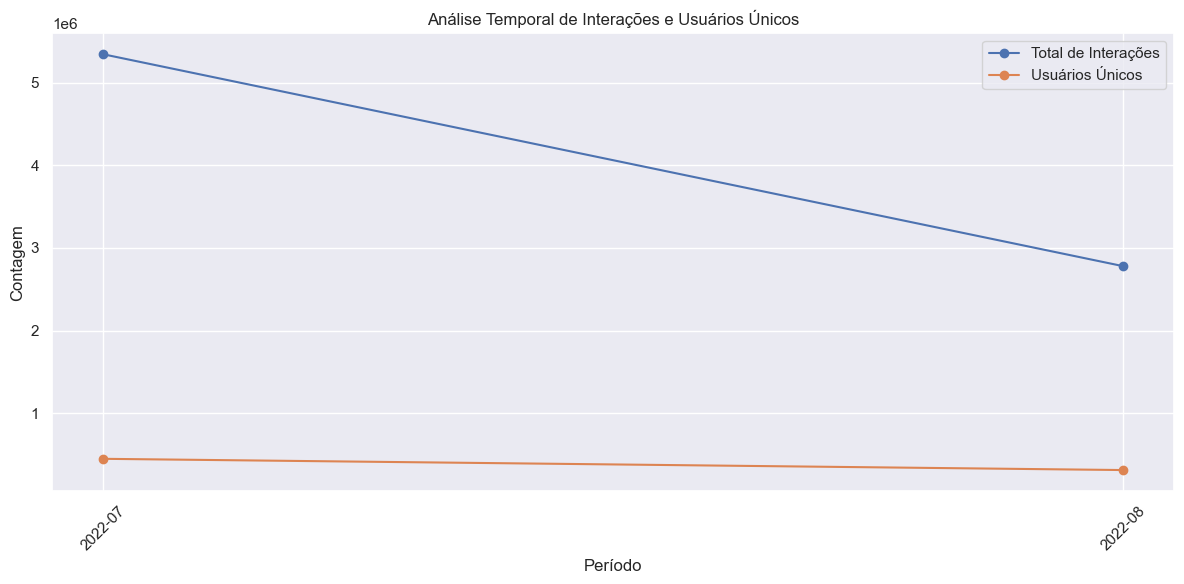


Estatísticas Gerais:
Total de interações: 2
Média de usuários únicos por mês: 378,821


In [11]:
# 4. Análise temporal
temporal_results = spark.sql("""
    SELECT 
        year,
        month,
        COUNT(*) as interactions,
        COUNT(DISTINCT userId) as unique_users
    FROM tab_treino
    GROUP BY year, month
    ORDER BY year, month
""").collect()

# Extrair dados
dates = [f"{row['year']}-{row['month']:02d}" for row in temporal_results]
interactions = [row['interactions'] for row in temporal_results]
unique_users = [row['unique_users'] for row in temporal_results]

plt.figure(figsize=(12, 6))
plt.plot(range(len(dates)), interactions, marker='o', label='Total de Interações')
plt.plot(range(len(dates)), unique_users, marker='o', label='Usuários Únicos')
plt.title('Análise Temporal de Interações e Usuários Únicos')
plt.xlabel('Período')
plt.ylabel('Contagem')
plt.xticks(range(len(dates)), dates, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular estatísticas usando SQL
stats = spark.sql("""
    SELECT 
        COUNT(*) as total_interactions,
        CAST(AVG(monthly_users) AS INT) as avg_monthly_users
    FROM (
        SELECT 
            year,
            month,
            COUNT(DISTINCT userId) as monthly_users
        FROM tab_treino
        GROUP BY year, month
    )
""").collect()[0]

print("\nEstatísticas Gerais:")
print(f"Total de interações: {stats['total_interactions']:,}")
print(f"Média de usuários únicos por mês: {stats['avg_monthly_users']:,}")

In [12]:
# Análise de sazonalidade
temporal_patterns = spark.sql("""
    SELECT 
        CAST(COUNT(*) AS INT) as total_interactions,
        CAST(COUNT(DISTINCT userId) AS INT) as unique_users,
        CAST(COUNT(*) / COUNT(DISTINCT userId) AS INT) as avg_interactions_per_user
    FROM tab_treino
""").collect()[0]

print("\n=== Padrões de Uso ===")
print(f"Total de Interações: {temporal_patterns['total_interactions']:,}")
print(f"Usuários Únicos: {temporal_patterns['unique_users']:,}")
print(f"Média de Interações por Usuário: {temporal_patterns['avg_interactions_per_user']}")


=== Padrões de Uso ===
Total de Interações: 8,123,951
Usuários Únicos: 577,942
Média de Interações por Usuário: 14


25/02/12 23:30:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/12 23:30:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/12 23:30:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/12 23:30:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/12 23:30:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/12 23:30:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/12 2

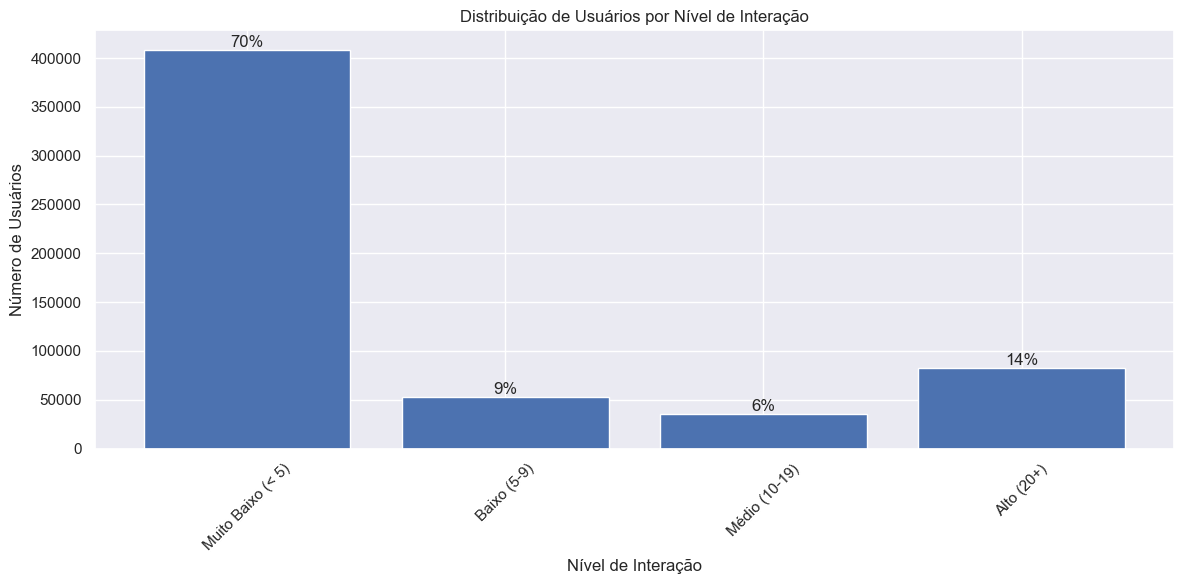

In [13]:
# 5. Análise de Cold-Start
cold_start_analysis = spark.sql("""
    WITH user_interaction_counts AS (
        SELECT 
            userId,
            COUNT(*) as interaction_count,
            CASE 
                WHEN COUNT(*) < 5 THEN 'Muito Baixo (< 5)'
                WHEN COUNT(*) < 10 THEN 'Baixo (5-9)'
                WHEN COUNT(*) < 20 THEN 'Médio (10-19)'
                ELSE 'Alto (20+)'
            END as interaction_level
        FROM tab_treino
        GROUP BY userId
    )
    SELECT 
        interaction_level,
        COUNT(*) as num_users,
        CAST(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS INT) as percentage
    FROM user_interaction_counts
    GROUP BY interaction_level
    ORDER BY 
        CASE interaction_level
            WHEN 'Muito Baixo (< 5)' THEN 1
            WHEN 'Baixo (5-9)' THEN 2
            WHEN 'Médio (10-19)' THEN 3
            WHEN 'Alto (20+)' THEN 4
        END
""").collect()

# Visualizar distribuição de usuários por nível de interação
levels = [row['interaction_level'] for row in cold_start_analysis]
users = [row['num_users'] for row in cold_start_analysis]
percentages = [row['percentage'] for row in cold_start_analysis]

plt.figure(figsize=(12, 6))
bars = plt.bar(levels, users)
plt.title('Distribuição de Usuários por Nível de Interação')
plt.xlabel('Nível de Interação')
plt.ylabel('Número de Usuários')
plt.xticks(rotation=45)

# Adicionar percentagens no topo das barras
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

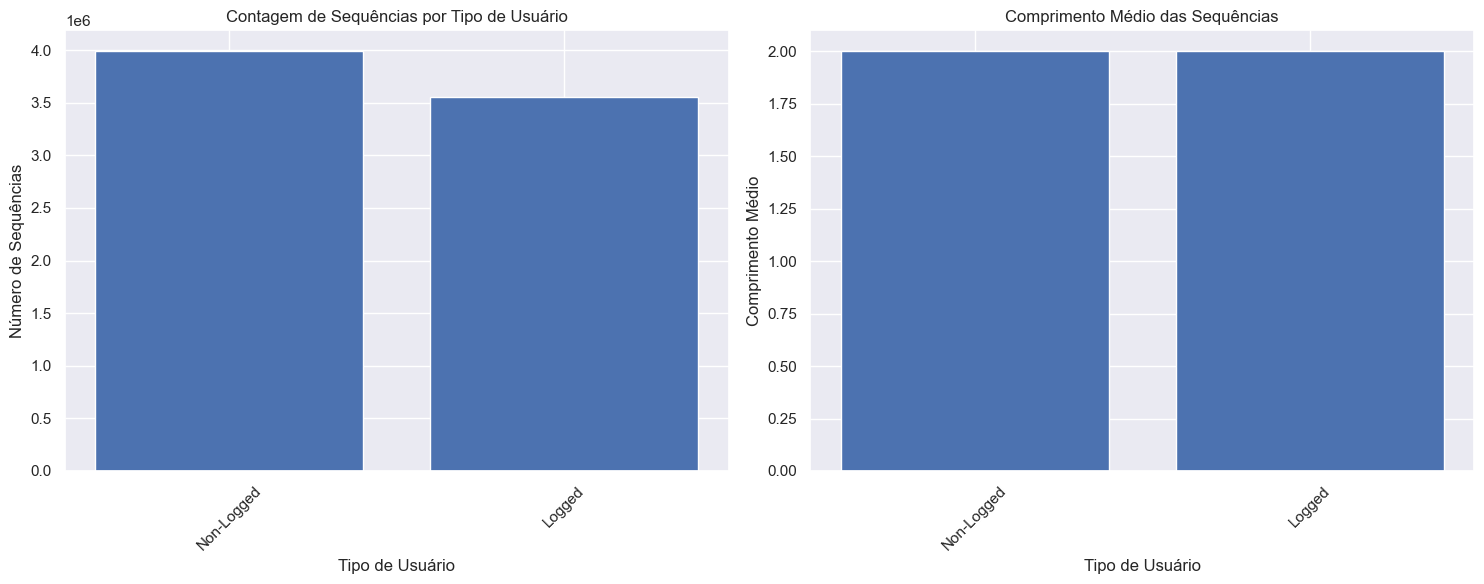

In [14]:
# 6. Análise de Sequência de Leitura
sequence_patterns = spark.sql("""
    WITH user_sequences AS (
        SELECT 
            userId,
            userType,
            COLLECT_LIST(history) OVER (
                PARTITION BY userId 
                ORDER BY timestampHistory
                ROWS BETWEEN 1 PRECEDING AND CURRENT ROW
            ) as sequence
        FROM tab_treino
    )
    SELECT 
        userType,
        COUNT(*) as sequence_count,
        CAST(AVG(size(sequence)) AS INT) as avg_sequence_length
    FROM user_sequences
    WHERE size(sequence) > 1
    GROUP BY userType
    ORDER BY sequence_count DESC
""").collect()

# Visualizar padrões de sequência
user_types = [row['userType'] for row in sequence_patterns]
seq_counts = [row['sequence_count'] for row in sequence_patterns]
avg_lengths = [row['avg_sequence_length'] for row in sequence_patterns]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de contagem de sequências
ax1.bar(user_types, seq_counts)
ax1.set_title('Contagem de Sequências por Tipo de Usuário')
ax1.set_xlabel('Tipo de Usuário')
ax1.set_ylabel('Número de Sequências')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de comprimento médio de sequências
ax2.bar(user_types, avg_lengths)
ax2.set_title('Comprimento Médio das Sequências')
ax2.set_xlabel('Tipo de Usuário')
ax2.set_ylabel('Comprimento Médio')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# 7. Análise de Correlação entre Métricas
correlation_data = spark.sql("""
    SELECT 
        CAST(CORR(numberOfClicksHistory, timeOnPageHistory) AS DECIMAL(10,2)) as clicks_time_corr,
        CAST(CORR(numberOfClicksHistory, scrollPercentageHistory) AS DECIMAL(10,2)) as clicks_scroll_corr,
        CAST(CORR(timeOnPageHistory, scrollPercentageHistory) AS DECIMAL(10,2)) as time_scroll_corr,
        CAST(CORR(pageVisitsCountHistory, numberOfClicksHistory) AS DECIMAL(10,2)) as visits_clicks_corr
    FROM tab_treino
""").collect()[0]

print("\nCorrelações entre Métricas de Engajamento:")
print(f"Clicks vs Tempo na Página: {correlation_data['clicks_time_corr']}")
print(f"Clicks vs Scroll: {correlation_data['clicks_scroll_corr']}")
print(f"Tempo vs Scroll: {correlation_data['time_scroll_corr']}")
print(f"Visitas vs Clicks: {correlation_data['visits_clicks_corr']}")



Correlações entre Métricas de Engajamento:
Clicks vs Tempo na Página: 0.52
Clicks vs Scroll: 0.00
Tempo vs Scroll: 0.00
Visitas vs Clicks: 0.28


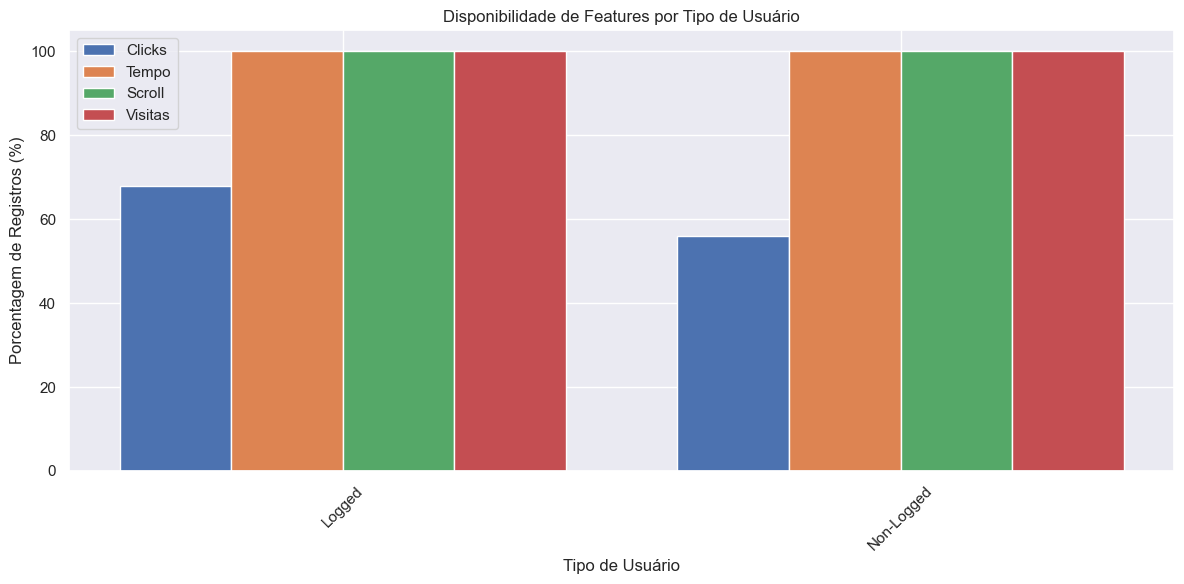

In [16]:
# 8. Features Importantes para o Modelo
feature_importance = spark.sql("""
    SELECT 
        userType,
        CAST(AVG(CASE WHEN numberOfClicksHistory > 0 THEN 1 ELSE 0 END) * 100 AS INT) as pct_with_clicks,
        CAST(AVG(CASE WHEN timeOnPageHistory > 0 THEN 1 ELSE 0 END) * 100 AS INT) as pct_with_time,
        CAST(AVG(CASE WHEN scrollPercentageHistory > 0 THEN 1 ELSE 0 END) * 100 AS INT) as pct_with_scroll,
        CAST(AVG(CASE WHEN pageVisitsCountHistory > 0 THEN 1 ELSE 0 END) * 100 AS INT) as pct_with_visits
    FROM tab_treino
    GROUP BY userType
    ORDER BY userType
""").collect()

# Visualizar importância das features
feature_data = pd.DataFrame([(row['userType'], 
                            row['pct_with_clicks'],
                            row['pct_with_time'],
                            row['pct_with_scroll'],
                            row['pct_with_visits']) for row in feature_importance],
                          columns=['userType', 'Clicks', 'Tempo', 'Scroll', 'Visitas'])

plt.figure(figsize=(12, 6))
x = range(len(feature_data['userType']))
width = 0.2

plt.bar([i - width*1.5 for i in x], feature_data['Clicks'], width, label='Clicks')
plt.bar([i - width*0.5 for i in x], feature_data['Tempo'], width, label='Tempo')
plt.bar([i + width*0.5 for i in x], feature_data['Scroll'], width, label='Scroll')
plt.bar([i + width*1.5 for i in x], feature_data['Visitas'], width, label='Visitas')

plt.xlabel('Tipo de Usuário')
plt.ylabel('Porcentagem de Registros (%)')
plt.title('Disponibilidade de Features por Tipo de Usuário')
plt.xticks(x, feature_data['userType'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

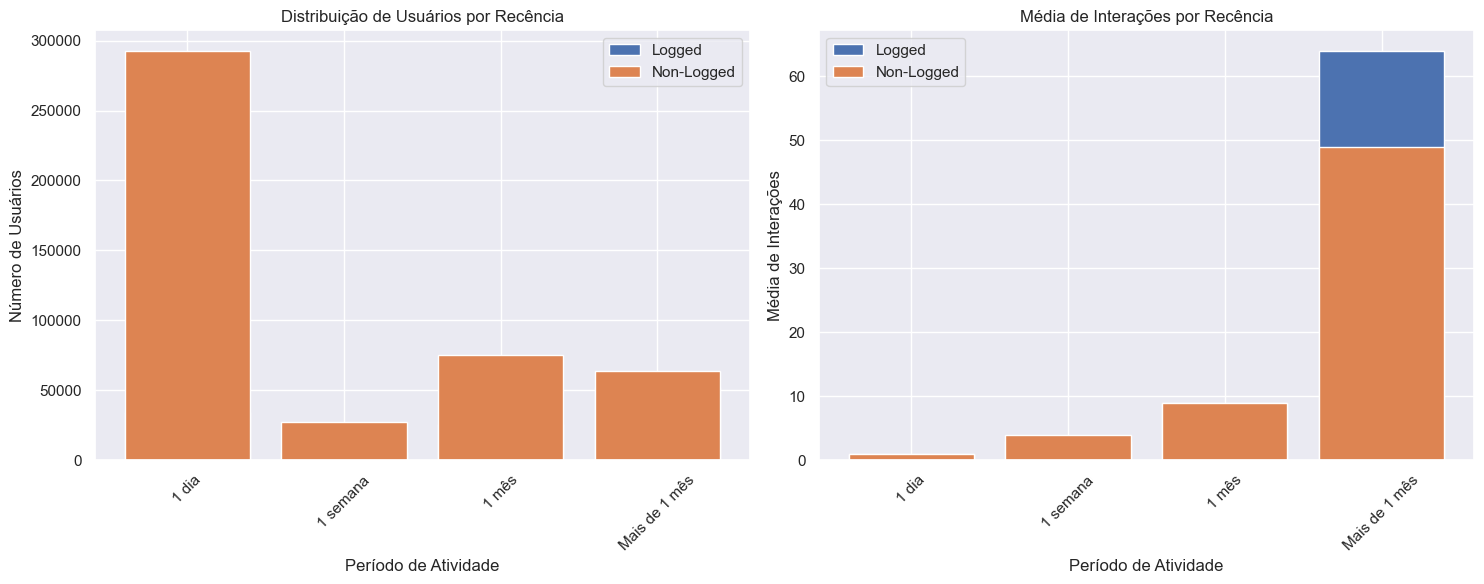

In [17]:
# 9. Análise de Recência
recency_analysis = spark.sql("""
    WITH user_recency AS (
        SELECT 
            userId,
            DATEDIFF(MAX(timestampHistory), MIN(timestampHistory)) as days_active,
            COUNT(*) as total_interactions,
            userType
        FROM tab_treino
        GROUP BY userId, userType
    )
    SELECT 
        CASE 
            WHEN days_active <= 1 THEN '1 dia'
            WHEN days_active <= 7 THEN '1 semana'
            WHEN days_active <= 30 THEN '1 mês'
            ELSE 'Mais de 1 mês'
        END as recency_bucket,
        userType,
        CAST(COUNT(*) AS INT) as num_users,
        CAST(AVG(total_interactions) AS INT) as avg_interactions
    FROM user_recency
    GROUP BY 
        CASE 
            WHEN days_active <= 1 THEN '1 dia'
            WHEN days_active <= 7 THEN '1 semana'
            WHEN days_active <= 30 THEN '1 mês'
            ELSE 'Mais de 1 mês'
        END,
        userType
    ORDER BY 
        CASE recency_bucket
            WHEN '1 dia' THEN 1
            WHEN '1 semana' THEN 2
            WHEN '1 mês' THEN 3
            ELSE 4
        END,
        userType
""").collect()

# Preparar dados para visualização
recency_data = [(row['recency_bucket'], row['userType'], 
                 row['num_users'], row['avg_interactions']) 
                for row in recency_analysis]
buckets = [row[0] for row in recency_data]
user_types = [row[1] for row in recency_data]
num_users = [row[2] for row in recency_data]
avg_interactions = [row[3] for row in recency_data]

# Criar dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Número de usuários por bucket de recência
for i, user_type in enumerate(set(user_types)):
    mask = [ut == user_type for ut in user_types]
    ax1.bar([b for b, m in zip(buckets, mask) if m],
            [n for n, m in zip(num_users, mask) if m],
            label=user_type)

ax1.set_title('Distribuição de Usuários por Recência')
ax1.set_xlabel('Período de Atividade')
ax1.set_ylabel('Número de Usuários')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Gráfico 2: Média de interações por bucket de recência
for i, user_type in enumerate(set(user_types)):
    mask = [ut == user_type for ut in user_types]
    ax2.bar([b for b, m in zip(buckets, mask) if m],
            [a for a, m in zip(avg_interactions, mask) if m],
            label=user_type)

ax2.set_title('Média de Interações por Recência')
ax2.set_xlabel('Período de Atividade')
ax2.set_ylabel('Média de Interações')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

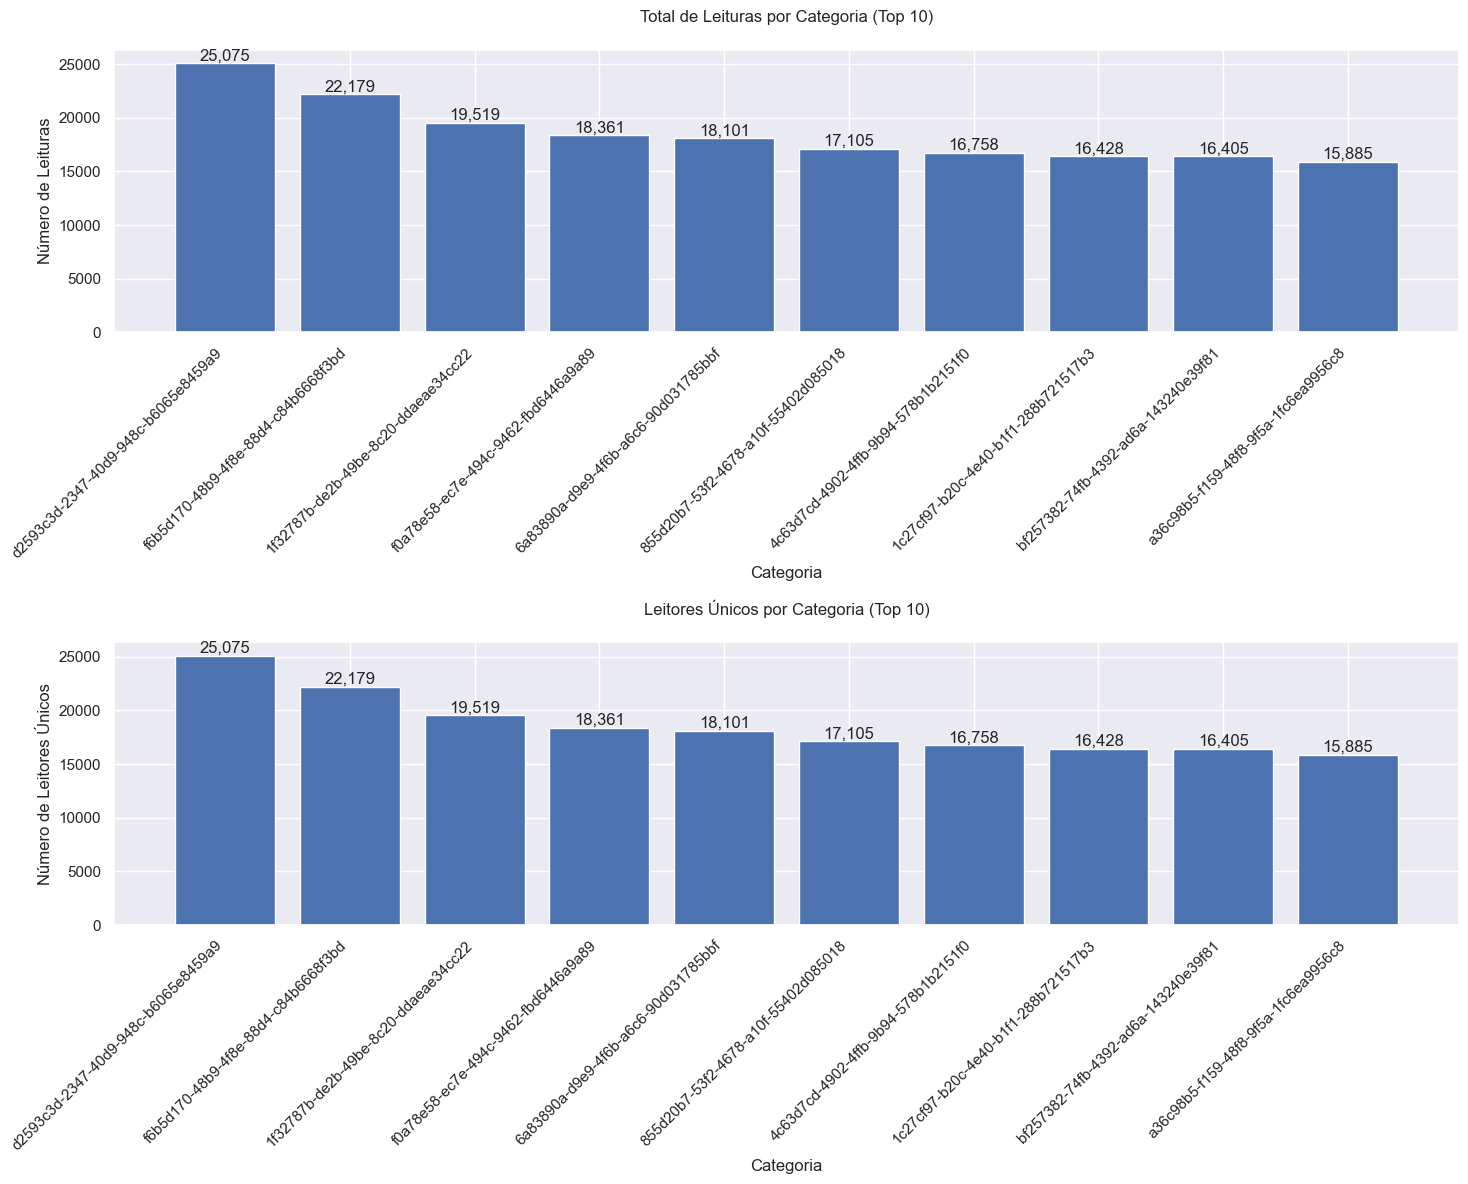


Estatísticas das Top 10 Categorias:

Categoria: d2593c3d-2347-40d9-948c-b6065e8459a9
Total de Leituras: 25,075
Leitores Únicos: 25,075
Tempo Médio de Leitura: 89275 segundos
Scroll Médio: 45%

Categoria: f6b5d170-48b9-4f8e-88d4-c84b6668f3bd
Total de Leituras: 22,179
Leitores Únicos: 22,179
Tempo Médio de Leitura: 89726 segundos
Scroll Médio: 45%

Categoria: 1f32787b-de2b-49be-8c20-ddaeae34cc22
Total de Leituras: 19,519
Leitores Únicos: 19,519
Tempo Médio de Leitura: 91848 segundos
Scroll Médio: 46%

Categoria: f0a78e58-ec7e-494c-9462-fbd6446a9a89
Total de Leituras: 18,361
Leitores Únicos: 18,361
Tempo Médio de Leitura: 97549 segundos
Scroll Médio: 46%

Categoria: 6a83890a-d9e9-4f6b-a6c6-90d031785bbf
Total de Leituras: 18,101
Leitores Únicos: 18,101
Tempo Médio de Leitura: 93999 segundos
Scroll Médio: 47%

Categoria: 855d20b7-53f2-4678-a10f-55402d085018
Total de Leituras: 17,105
Leitores Únicos: 17,105
Tempo Médio de Leitura: 91297 segundos
Scroll Médio: 68%

Categoria: 4c63d7cd-4902-4

25/02/13 01:48:12 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 913294 ms exceeds timeout 120000 ms
25/02/13 01:48:12 WARN SparkContext: Killing executors is not supported by current scheduler.
25/02/13 01:48:17 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [25]:
# Análise de Categorias de Notícias (Top 10)
top_categories = spark.sql("""
    SELECT 
        i.page as category,
        CAST(COUNT(DISTINCT t.userId) AS INT) as unique_readers,
        CAST(COUNT(*) AS INT) as total_reads,
        CAST(AVG(t.timeOnPageHistory) AS INT) as avg_time_spent,
        CAST(AVG(t.scrollPercentageHistory) AS INT) as avg_scroll
    FROM tab_treino t
    JOIN tab_itens i ON t.history = i.page
    GROUP BY i.page
    HAVING COUNT(*) > 100
    ORDER BY total_reads DESC
    LIMIT 10
""").collect()

# Preparar dados para visualização
categories = [row['category'] for row in top_categories]
unique_readers = [row['unique_readers'] for row in top_categories]
total_reads = [row['total_reads'] for row in top_categories]
avg_time = [row['avg_time_spent'] for row in top_categories]
avg_scroll = [row['avg_scroll'] for row in top_categories]

# Criar visualização com dois subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Gráfico 1: Total de Leituras por Categoria
bars1 = ax1.bar(categories, total_reads)
ax1.set_title('Total de Leituras por Categoria (Top 10)', pad=20)
ax1.set_xlabel('Categoria')
ax1.set_ylabel('Número de Leituras')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Adicionar valores no topo das barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Gráfico 2: Leitores Únicos por Categoria
bars2 = ax2.bar(categories, unique_readers)
ax2.set_title('Leitores Únicos por Categoria (Top 10)', pad=20)
ax2.set_xlabel('Categoria')
ax2.set_ylabel('Número de Leitores Únicos')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Adicionar valores no topo das barras
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Ajustar layout
plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("\nEstatísticas das Top 10 Categorias:")
for row in top_categories:
    print(f"\nCategoria: {row['category']}")
    print(f"Total de Leituras: {row['total_reads']:,}")
    print(f"Leitores Únicos: {row['unique_readers']:,}")
    print(f"Tempo Médio de Leitura: {row['avg_time_spent']} segundos")
    print(f"Scroll Médio: {row['avg_scroll']}%")

In [1]:
# Inicializar Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Validation") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.cores", "2") \
    .config("spark.python.worker.memory", "2g") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.memory.fraction", "0.7") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.parquet.compression.codec", "snappy") \
    .getOrCreate()

# Caminho para os dados processados
output_path = "datalake/silver/itens_embeddings"  # ajuste o caminho conforme necessário

# Ler e verificar os dados
df = spark.read.parquet(output_path)

# 1. Ver o schema
print("Schema dos dados:")
df.printSchema()

# 2. Contar registros
total = df.count()
print(f"\nTotal de registros: {total}")

# 3. Ver exemplo dos dados
print("\nExemplo de registro:")
df.select("title", "tfidf_features").show(1, truncate=False)

# 4. Ver distribuição por ano
print("\nDistribuição por ano:")
df.groupBy("year").count().orderBy("year").show()

# 5. Verificar features
from pyspark.sql.functions import col, count, when
print("\nEstatísticas das features:")
df.select(
    count("*").alias("total_records"),
    count("tfidf_features").alias("records_with_features"),
    count(when(col("tfidf_features").isNull(), True)).alias("null_features")
).show()

# Fechar a sessão quando terminar
spark.stop()

Schema dos dados:
root
 |-- page: string (nullable = true)
 |-- issued: timestamp (nullable = true)
 |-- modified: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- tfidf_features: vector (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)


Total de registros: 255603

Exemplo de registro:
+--------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                        